--- Simulation Start: 16-QAM (Offset Method - 10GHz) ---
Frequency: 50.0 GHz (Carrier), 1600.0 GHz (Sampling)
Total Bits: 8000, SNR: 12 dB, RRAM Noise: 0.25%

Mapping Matrices to RRAM (Offset Method)...
Mapping complete.

Scale Factor: 30.3593-0.3103j

Transmitting Random Stream...
Analysis...

[Results] 16-QAM (Offset Method - Single Array)
EVM: 4.82%


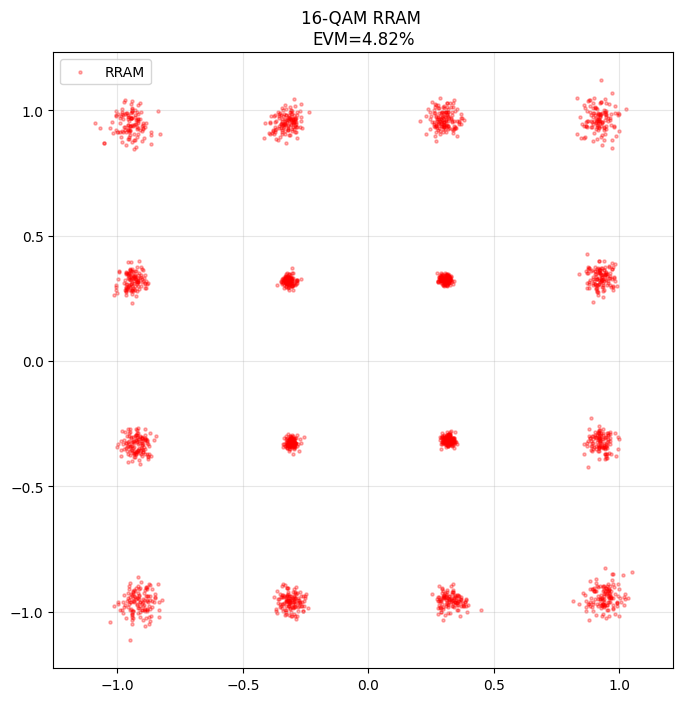

Saved to rram_offset_16qam_results.csv


In [ ]:
#16QAM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import firwin

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):

    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)


    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)


    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)


    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]

    return rram_matrix


def generate_lpf_coefficients(num_taps, cutoff_freq, sampling_freq):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    return firwin(num_taps, normalized_cutoff, window='hamming')

def create_toeplitz_matrix(coeffs, num_inputs):
    num_taps = len(coeffs)
    output_len = num_inputs + num_taps - 1
    toeplitz_matrix = np.zeros((num_inputs, output_len))
    for i in range(num_inputs):
        toeplitz_matrix[i, i:i+num_taps] = coeffs
    return toeplitz_matrix[:, :2*num_inputs]

def create_modulation_matrix(ideal_symbols, fc, t_sampled):
    N = len(t_sampled)
    num_symbols = len(ideal_symbols)
    mod_matrix = np.zeros((num_symbols, N))

    cos_carrier = np.cos(2 * np.pi * fc * t_sampled)
    sin_carrier = np.sin(2 * np.pi * fc * t_sampled)

    for i, symbol in enumerate(ideal_symbols):
        I_sym = np.real(symbol)
        Q_sym = np.imag(symbol)
        mod_matrix[i, :] = I_sym * cos_carrier - Q_sym * sin_carrier

    return mod_matrix

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    if np.isinf(snr_db): return signal
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def integrate_output(I_out, Q_out, N):
    power = I_out**2 + Q_out**2
    if len(power) < N: return 0, 0
    energy = np.convolve(power, np.ones(N, dtype=float), mode='valid')
    if len(energy) == 0: return 0, 0
    start = int(np.argmax(energy))
    end = start + N
    I_hat = np.sum(I_out[start:end])
    Q_hat = np.sum(Q_out[start:end])
    return I_hat, Q_hat

def bits_to_symbol_indices(bits, bits_per_symbol):
    num_symbols = len(bits) // bits_per_symbol
    bits = bits[:num_symbols * bits_per_symbol]
    bits_reshaped = bits.reshape(-1, bits_per_symbol)
    powers_of_two = 1 << np.arange(bits_per_symbol)[::-1]
    symbol_indices = bits_reshaped @ powers_of_two
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol):
    bits_list = []
    for idx in indices:
        binary_string = format(idx, f'0{bits_per_symbol}b')
        bits = [int(b) for b in binary_string]
        bits_list.extend(bits)
    return np.array(bits_list)

def decide_symbol_index(received_point, reference_symbols):
    distances = np.abs(received_point - reference_symbols)
    closest_idx = np.argmin(distances)
    return closest_idx

def gray_to_binary(n):
    mask = n
    while mask != 0:
        mask >>= 1
        n ^= mask
    return n

def main():
    N = 64; fs = 1600e9; fc = 50e9; num_lpf_taps = N + 1; lpf_cutoff = 50e9
    Ts = 1 / fs; t_sampled = np.arange(N) * Ts

    bits_per_symbol = 4
    M = 16

    num_test_symbols = 200000
    total_bits = num_test_symbols * bits_per_symbol

    SNR_dB = 12
    read_noise_stddev_scaled = 0.0025


    g_min = 1e-3; g_max = 8e-3; states = 76; nonlinearity = 0.38

    print(f"--- Simulation Start: 16-QAM (Offset Method - 10GHz) ---")
    print(f"Frequency: {fc/1e9} GHz (Carrier), {fs/1e9} GHz (Sampling)")
    print(f"Total Bits: {total_bits}, SNR: {SNR_dB} dB, RRAM Noise: {read_noise_stddev_scaled*100}%")

    b_coeffs = generate_lpf_coefficients(num_lpf_taps, lpf_cutoff, fs)
    lpf_toeplitz = create_toeplitz_matrix(b_coeffs, N)

    t = np.arange(N) / fs
    cos_carrier = np.cos(2 * np.pi * fc * t)
    sin_carrier_neg = -np.sin(2 * np.pi * fc * t)

    I_demod_ideal = np.diag(cos_carrier) @ lpf_toeplitz
    Q_demod_ideal = np.diag(sin_carrier_neg) @ lpf_toeplitz

    ideal_symbols = []
    L = 4
    k_half = 2
    mask_half = 0x3

    for i in range(M):
        i_bits_gray = (i >> k_half) & mask_half
        q_bits_gray = i & mask_half

        i_idx = gray_to_binary(i_bits_gray)
        q_idx = gray_to_binary(q_bits_gray)

        I_val = 2 * i_idx - 3
        Q_val = -(2 * q_idx - 3)

        symbol_complex = (I_val + 1j * Q_val) / np.sqrt(10)
        ideal_symbols.append(symbol_complex)

    ideal_symbols = np.array(ideal_symbols)

    M_mod_ideal = create_modulation_matrix(ideal_symbols, fc, t_sampled)

    print("\nMapping Matrices to RRAM (Offset Method)...")

    min_mod = M_mod_ideal.min()
    offset_mod = -min_mod
    target_mod = M_mod_ideal + offset_mod
    max_mod = target_mod.max()
    G_mod_rram = map_weights_to_conductance_linear(target_mod, g_min, g_max, states, nonlinearity, max_mod)

    min_demod = min(I_demod_ideal.min(), Q_demod_ideal.min())
    offset_demod = -min_demod
    I_target = I_demod_ideal + offset_demod
    Q_target = Q_demod_ideal + offset_demod
    max_demod = max(I_target.max(), Q_target.max())

    G_I_rram = map_weights_to_conductance_linear(I_target, g_min, g_max, states, nonlinearity, max_demod)
    G_Q_rram = map_weights_to_conductance_linear(Q_target, g_min, g_max, states, nonlinearity, max_demod)

    gain_mod = max_mod / (g_max - g_min)
    gain_demod = max_demod / (g_max - g_min)

    print("Mapping complete.\n")

    cal_sym = ideal_symbols[0]
    cal_sig = np.real(cal_sym)*np.cos(2*np.pi*fc*t) - np.imag(cal_sym)*np.sin(2*np.pi*fc*t)
    cal_I_ideal = cal_sig @ I_demod_ideal
    cal_Q_ideal = cal_sig @ Q_demod_ideal
    I_meas, Q_meas = integrate_output(cal_I_ideal, cal_Q_ideal, N)
    cal_res = I_meas + 1j * Q_meas
    scale_factor = cal_res / cal_sym if cal_res != 0 else 1.0
    print(f"Scale Factor: {scale_factor:.4f}\n")

    tx_bits = np.random.randint(0, 2, total_bits)
    tx_indices = bits_to_symbol_indices(tx_bits, bits_per_symbol)

    rx_points_rram = []
    rx_points_ideal = []

    print("Transmitting Random Stream...")

    for idx in tx_indices:
        v_in = np.zeros(len(ideal_symbols)); v_in[idx] = 1.0

        tx_sig_ideal = v_in @ M_mod_ideal
        rx_sig_ideal = tx_sig_ideal
        I_out_ideal = rx_sig_ideal @ I_demod_ideal
        Q_out_ideal = rx_sig_ideal @ Q_demod_ideal
        I_val_ideal, Q_val_ideal = integrate_output(I_out_ideal, Q_out_ideal, N)
        rx_points_ideal.append((I_val_ideal + 1j*Q_val_ideal) / scale_factor)

        mod_raw = v_in @ G_mod_rram

        gain_inv_mod = (g_max - g_min) / max_mod
        mod_noise = np.random.normal(0, read_noise_stddev_scaled * gain_inv_mod, mod_raw.shape)
        mod_noisy = mod_raw + mod_noise

        g_min_bias_mod = g_min * np.sum(v_in)
        offset_bias_mod = offset_mod * np.sum(v_in)
        tx_sig_rram = (mod_noisy - g_min_bias_mod) * gain_mod - offset_bias_mod

        rx_sig_rram = add_awgn(tx_sig_rram, SNR_dB)

        I_out_raw = rx_sig_rram @ G_I_rram
        Q_out_raw = rx_sig_rram @ G_Q_rram

        gain_inv_demod = (g_max - g_min) / max_demod
        read_std_demod = read_noise_stddev_scaled * gain_inv_demod
        I_out_raw += np.random.normal(0, read_std_demod, I_out_raw.shape)
        Q_out_raw += np.random.normal(0, read_std_demod, Q_out_raw.shape)

        rx_sum = np.sum(rx_sig_rram)
        g_min_bias_demod = g_min * rx_sum
        offset_bias_demod = offset_demod * rx_sum

        I_final = (I_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod
        Q_final = (Q_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod

        I_val, Q_val = integrate_output(I_final, Q_final, N)
        rx_points_rram.append((I_val + 1j*Q_val) / scale_factor)

    rx_points_rram = np.array(rx_points_rram)
    rx_points_ideal = np.array(rx_points_ideal)

    print("Analysis...")
    rx_indices = [decide_symbol_index(p, ideal_symbols) for p in rx_points_rram]
    rx_bits = symbol_indices_to_bits(rx_indices, bits_per_symbol)

    tx_ideal = ideal_symbols[tx_indices]
    evm = np.sqrt(np.mean(np.abs(rx_points_rram - tx_ideal)**2)) / np.sqrt(np.mean(np.abs(ideal_symbols)**2)) * 100

    print(f"\n[Results] 16-QAM (Offset Method - Single Array)")
    print(f"EVM: {evm:.2f}%")

    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(rx_points_rram), np.imag(rx_points_rram), c='r', s=5, alpha=0.3, label='RRAM')
    plt.title(f"16-QAM RRAM \nEVM={evm:.2f}%")
    plt.grid(True, alpha=0.3); plt.axis('equal'); plt.legend()
    plt.show()

    df = pd.DataFrame({
        'Tx_Idx': tx_indices, 'Rx_Idx': rx_indices,
        'Tx_I': np.real(tx_ideal), 'Tx_Q': np.imag(tx_ideal),
        'Rx_Ideal_I': np.real(rx_points_ideal), 'Rx_Ideal_Q': np.imag(rx_points_ideal),
        'Rx_RRAM_I': np.real(rx_points_rram), 'Rx_RRAM_Q': np.imag(rx_points_rram)
    })
    df.to_csv('rram_offset_16qam_results.csv', index=False)
    print("Saved to rram_offset_16qam_results.csv")

if __name__ == '__main__':
    main()

--- Simulation Start: 64-QAM (Offset Method - 10GHz) ---
Frequency: 50.0 GHz (Carrier), 1066.7 GHz (Sampling)
Total Bits: 12000, SNR: 10 dB, RRAM Noise: 0.25%

Mapping Matrices to RRAM (Offset Method)...
Mapping complete.

Scale Factor: 31.0759-0.1629j

Transmitting Random Stream...
Analysis...

[Results] 64-QAM (Offset Method - Single Array)
EVM: 5.62%


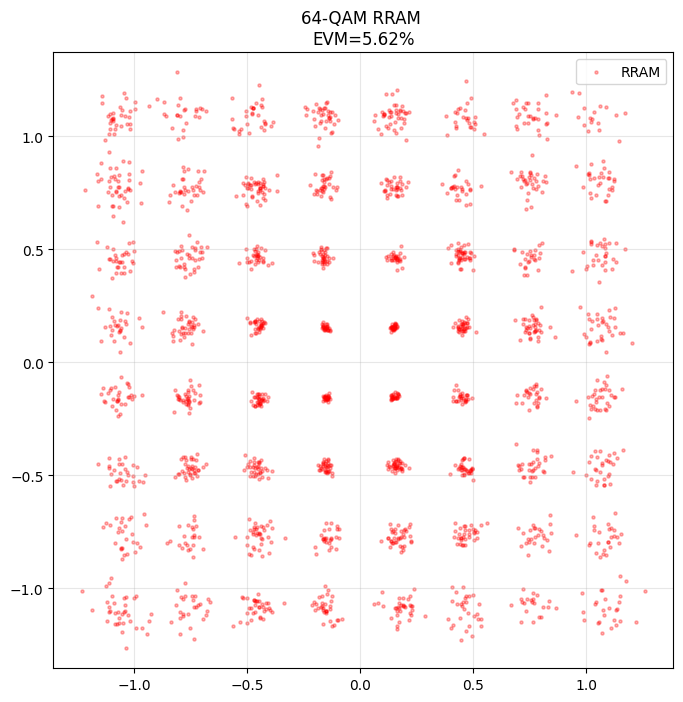

Saved to rram_offset_64qam_results.csv


In [ ]:
# 64-QAM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import firwin

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)


    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]

    return rram_matrix

def generate_lpf_coefficients(num_taps, cutoff_freq, sampling_freq):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    return firwin(num_taps, normalized_cutoff, window='hamming')

def create_toeplitz_matrix(coeffs, num_inputs):
    num_taps = len(coeffs)
    output_len = num_inputs + num_taps - 1
    toeplitz_matrix = np.zeros((num_inputs, output_len))
    for i in range(num_inputs):
        toeplitz_matrix[i, i:i+num_taps] = coeffs
    return toeplitz_matrix[:, :2*num_inputs]

def create_modulation_matrix(ideal_symbols, fc, t_sampled):
    N = len(t_sampled)
    num_symbols = len(ideal_symbols)
    mod_matrix = np.zeros((num_symbols, N))

    cos_carrier = np.cos(2 * np.pi * fc * t_sampled)
    sin_carrier = np.sin(2 * np.pi * fc * t_sampled)

    for i, symbol in enumerate(ideal_symbols):
        I_sym = np.real(symbol)
        Q_sym = np.imag(symbol)
        mod_matrix[i, :] = I_sym * cos_carrier - Q_sym * sin_carrier

    return mod_matrix

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    if np.isinf(snr_db): return signal
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def integrate_output(I_out, Q_out, N):
    """복조된 파형을 적분하여 좌표로 변환"""
    power = I_out**2 + Q_out**2
    if len(power) < N: return 0, 0
    energy = np.convolve(power, np.ones(N, dtype=float), mode='valid')
    if len(energy) == 0: return 0, 0
    start = int(np.argmax(energy))
    end = start + N
    I_hat = np.sum(I_out[start:end])
    Q_hat = np.sum(Q_out[start:end])
    return I_hat, Q_hat

def bits_to_symbol_indices(bits, bits_per_symbol):
    num_symbols = len(bits) // bits_per_symbol
    bits = bits[:num_symbols * bits_per_symbol]
    bits_reshaped = bits.reshape(-1, bits_per_symbol)
    powers_of_two = 1 << np.arange(bits_per_symbol)[::-1]
    symbol_indices = bits_reshaped @ powers_of_two
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol):
    bits_list = []
    for idx in indices:
        binary_string = format(idx, f'0{bits_per_symbol}b')
        bits = [int(b) for b in binary_string]
        bits_list.extend(bits)
    return np.array(bits_list)

def decide_symbol_index(received_point, reference_symbols):
    distances = np.abs(received_point - reference_symbols)
    closest_idx = np.argmin(distances)
    return closest_idx

def gray_to_binary(n):
    mask = n
    while mask != 0:
        mask >>= 1
        n ^= mask
    return n

def main():
    N = 64
    fs = 1066.7e9
    fc = 50e9
    num_lpf_taps = N + 1
    lpf_cutoff = 50e9

    Ts = 1 / fs; t_sampled = np.arange(N) * Ts

    bits_per_symbol = 6; M = 64

    num_test_symbols = 200000
    total_bits = num_test_symbols * bits_per_symbol

    SNR_dB = 10; read_noise_stddev_scaled = 0.0025

    g_min = 1e-3; g_max = 8e-3; states = 76; nonlinearity = 0.38

    print(f"--- Simulation Start: 64-QAM (Offset Method - 10GHz) ---")
    print(f"Frequency: {fc/1e9} GHz (Carrier), {fs/1e9} GHz (Sampling)")
    print(f"Total Bits: {total_bits}, SNR: {SNR_dB} dB, RRAM Noise: {read_noise_stddev_scaled*100}%")

    b_coeffs = generate_lpf_coefficients(num_lpf_taps, lpf_cutoff, fs)
    lpf_toeplitz = create_toeplitz_matrix(b_coeffs, N)

    t = np.arange(N) / fs
    cos_carrier = np.cos(2 * np.pi * fc * t)
    sin_carrier_neg = -np.sin(2 * np.pi * fc * t)

    I_demod_ideal = np.diag(cos_carrier) @ lpf_toeplitz
    Q_demod_ideal = np.diag(sin_carrier_neg) @ lpf_toeplitz


    L = 8
    k_half = 3
    mask_half = 0x7

    ideal_symbols = []
    for i in range(M):
        i_bits_gray = (i >> k_half) & mask_half
        q_bits_gray = i & mask_half

        i_idx = gray_to_binary(i_bits_gray)
        q_idx = gray_to_binary(q_bits_gray)

        I_val = 2 * i_idx - 7
        Q_val = -(2 * q_idx - 7)

        avg_power = 42.0
        symbol_complex = (I_val + 1j * Q_val) / np.sqrt(avg_power)
        ideal_symbols.append(symbol_complex)

    ideal_symbols = np.array(ideal_symbols)

    M_mod_ideal = create_modulation_matrix(ideal_symbols, fc, t_sampled)

    print("\nMapping Matrices to RRAM (Offset Method)...")

    min_mod = M_mod_ideal.min()
    offset_mod = -min_mod
    target_mod = M_mod_ideal + offset_mod
    max_mod = target_mod.max()
    G_mod_rram = map_weights_to_conductance_linear(target_mod, g_min, g_max, states, nonlinearity, max_mod)

    min_demod = min(I_demod_ideal.min(), Q_demod_ideal.min())
    offset_demod = -min_demod
    I_target = I_demod_ideal + offset_demod
    Q_target = Q_demod_ideal + offset_demod
    max_demod = max(I_target.max(), Q_target.max())

    G_I_rram = map_weights_to_conductance_linear(I_target, g_min, g_max, states, nonlinearity, max_demod)
    G_Q_rram = map_weights_to_conductance_linear(Q_target, g_min, g_max, states, nonlinearity, max_demod)

    gain_mod = max_mod / (g_max - g_min)
    gain_demod = max_demod / (g_max - g_min)

    print("Mapping complete.\n")

    cal_sym = ideal_symbols[0]
    cal_sig = np.real(cal_sym)*np.cos(2*np.pi*fc*t) - np.imag(cal_sym)*np.sin(2*np.pi*fc*t)
    cal_I_ideal = cal_sig @ I_demod_ideal
    cal_Q_ideal = cal_sig @ Q_demod_ideal
    I_meas, Q_meas = integrate_output(cal_I_ideal, cal_Q_ideal, N)
    cal_res = I_meas + 1j * Q_meas
    scale_factor = cal_res / cal_sym if cal_res != 0 else 1.0
    print(f"Scale Factor: {scale_factor:.4f}\n")

    tx_bits = np.random.randint(0, 2, total_bits)
    tx_indices = bits_to_symbol_indices(tx_bits, bits_per_symbol)

    rx_points_rram = []
    rx_points_ideal = []

    print("Transmitting Random Stream...")

    for idx in tx_indices:
        v_in = np.zeros(len(ideal_symbols)); v_in[idx] = 1.0

        tx_sig_ideal = v_in @ M_mod_ideal
        rx_sig_ideal = tx_sig_ideal
        I_out_ideal = rx_sig_ideal @ I_demod_ideal
        Q_out_ideal = rx_sig_ideal @ Q_demod_ideal
        I_val_ideal, Q_val_ideal = integrate_output(I_out_ideal, Q_out_ideal, N)
        rx_points_ideal.append((I_val_ideal + 1j*Q_val_ideal) / scale_factor)

        mod_raw = v_in @ G_mod_rram

        gain_inv_mod = (g_max - g_min) / max_mod
        mod_noise = np.random.normal(0, read_noise_stddev_scaled * gain_inv_mod, mod_raw.shape)
        mod_noisy = mod_raw + mod_noise

        g_min_bias_mod = g_min * np.sum(v_in)
        offset_bias_mod = offset_mod * np.sum(v_in)
        tx_sig_rram = (mod_noisy - g_min_bias_mod) * gain_mod - offset_bias_mod

        rx_sig_rram = add_awgn(tx_sig_rram, SNR_dB)

        I_out_raw = rx_sig_rram @ G_I_rram
        Q_out_raw = rx_sig_rram @ G_Q_rram

        gain_inv_demod = (g_max - g_min) / max_demod
        read_std_demod = read_noise_stddev_scaled * gain_inv_demod
        I_out_raw += np.random.normal(0, read_std_demod, I_out_raw.shape)
        Q_out_raw += np.random.normal(0, read_std_demod, Q_out_raw.shape)

        rx_sum = np.sum(rx_sig_rram)
        g_min_bias_demod = g_min * rx_sum
        offset_bias_demod = offset_demod * rx_sum

        I_final = (I_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod
        Q_final = (Q_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod

        I_val, Q_val = integrate_output(I_final, Q_final, N)
        rx_points_rram.append((I_val + 1j*Q_val) / scale_factor)

    rx_points_rram = np.array(rx_points_rram)
    rx_points_ideal = np.array(rx_points_ideal)

    print("Analysis...")
    rx_indices = [decide_symbol_index(p, ideal_symbols) for p in rx_points_rram]
    rx_bits = symbol_indices_to_bits(rx_indices, bits_per_symbol)


    tx_ideal = ideal_symbols[tx_indices]

    evm = np.sqrt(np.mean(np.abs(rx_points_rram - rx_points_ideal)**2)) / np.sqrt(np.mean(np.abs(ideal_symbols)**2)) * 100

    print(f"\n[Results] 64-QAM (Offset Method - Single Array)")
    print(f"EVM: {evm:.2f}%")

    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(rx_points_rram), np.imag(rx_points_rram), c='r', s=5, alpha=0.3, label='RRAM')

    plt.title(f"64-QAM RRAM \nEVM={evm:.2f}%")
    plt.grid(True, alpha=0.3); plt.axis('equal'); plt.legend()
    plt.show()

    # Save
    df = pd.DataFrame({
        'Tx_Idx': tx_indices, 'Rx_Idx': rx_indices,
        'Tx_I': np.real(tx_ideal), 'Tx_Q': np.imag(tx_ideal),
        'Rx_Ideal_I': np.real(rx_points_ideal), 'Rx_Ideal_Q': np.imag(rx_points_ideal),
        'Rx_RRAM_I': np.real(rx_points_rram), 'Rx_RRAM_Q': np.imag(rx_points_rram)
    })
    df.to_csv('rram_offset_64qam_results.csv', index=False)
    print("Saved to rram_offset_64qam_results.csv")

if __name__ == '__main__':
    main()

--- Simulation Start: 256-QAM (Offset Method) ---
Freq: 50.0GHz, Sampling: 800.0GHz
SNR: 15 dB, RRAM States: 76
Mapping RRAM Matrices...
Calibration Scale Factor: 31.2341+0.2668j

Processing Symbols...
[Results] SNR=15dB, EVM: 3.48%


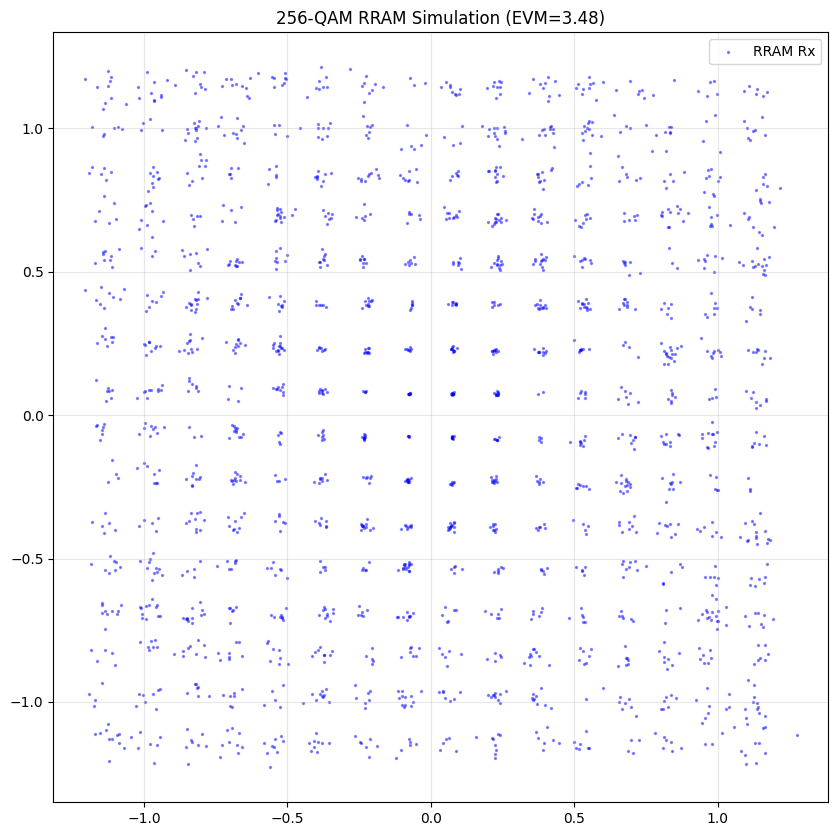

Constellation points saved to 'rram_256qam_constellation.csv'


In [ ]:
# 256-QAM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import firwin

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)

    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]

    return rram_matrix

def generate_lpf_coefficients(num_taps, cutoff_freq, sampling_freq):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    return firwin(num_taps, normalized_cutoff, window='hamming')

def create_toeplitz_matrix(coeffs, num_inputs):
    num_taps = len(coeffs)
    output_len = num_inputs + num_taps - 1
    toeplitz_matrix = np.zeros((num_inputs, output_len))
    for i in range(num_inputs):
        toeplitz_matrix[i, i:i+num_taps] = coeffs
    return toeplitz_matrix[:, :2*num_inputs]

def create_modulation_matrix(ideal_symbols, fc, t_sampled):
    """M-QAM 변조를 위한 (M x N) 파형 행렬 생성"""
    N = len(t_sampled)
    num_symbols = len(ideal_symbols)
    mod_matrix = np.zeros((num_symbols, N))

    cos_carrier = np.cos(2 * np.pi * fc * t_sampled)
    sin_carrier = np.sin(2 * np.pi * fc * t_sampled)

    for i, symbol in enumerate(ideal_symbols):
        I_sym = np.real(symbol)
        Q_sym = np.imag(symbol)
        mod_matrix[i, :] = I_sym * cos_carrier - Q_sym * sin_carrier

    return mod_matrix

def add_awgn(signal, snr_db):
    """신호에 AWGN(가우시안 채널 잡음) 추가"""
    if len(signal.shape) > 1:
        signal_power = np.mean(np.abs(signal)**2, axis=1, keepdims=True)
        if np.isinf(snr_db): return signal
        snr_linear = 10**(snr_db / 10.0)
        noise_power = signal_power / snr_linear
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    else:
        signal_power = np.mean(np.abs(signal)**2)
        if np.isinf(snr_db): return signal
        snr_linear = 10**(snr_db / 10.0)
        noise_power = signal_power / snr_linear
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

    return signal + noise

def integrate_output(I_out, Q_out, N):
    """복조된 파형을 적분하여 좌표로 변환 (Vectorized for batch)"""
    if len(I_out.shape) > 1:
        num_symbols = I_out.shape[0]
        I_hats = np.zeros(num_symbols)
        Q_hats = np.zeros(num_symbols)

        ones_kernel = np.ones(N, dtype=float)

        for i in range(num_symbols):
            power = I_out[i]**2 + Q_out[i]**2
            energy = np.convolve(power, ones_kernel, mode='valid')
            if len(energy) == 0:
                start = 0
            else:
                start = int(np.argmax(energy))
            end = start + N
            if end > len(I_out[i]): end = len(I_out[i])

            I_hats[i] = np.sum(I_out[i, start:end])
            Q_hats[i] = np.sum(Q_out[i, start:end])

        return I_hats, Q_hats

    else:
        power = I_out**2 + Q_out**2
        if len(power) < N: return 0, 0
        energy = np.convolve(power, np.ones(N, dtype=float), mode='valid')
        if len(energy) == 0: return 0, 0
        start = int(np.argmax(energy))
        end = start + N
        return np.sum(I_out[start:end]), np.sum(Q_out[start:end])

def bits_to_symbol_indices(bits, bits_per_symbol):
    num_symbols = len(bits) // bits_per_symbol
    bits = bits[:num_symbols * bits_per_symbol]
    bits_reshaped = bits.reshape(-1, bits_per_symbol)
    powers_of_two = 1 << np.arange(bits_per_symbol)[::-1]
    symbol_indices = bits_reshaped @ powers_of_two
    return symbol_indices

def symbol_indices_to_bits(indices, bits_per_symbol):
    n_symbols = len(indices)
    bits = np.zeros((n_symbols, bits_per_symbol), dtype=int)
    for i in range(bits_per_symbol):
        bits[:, i] = (indices >> (bits_per_symbol - 1 - i)) & 1
    return bits.flatten()

def decide_symbol_index(received_points, reference_symbols):
    dists = np.abs(received_points[:, None] - reference_symbols[None, :])
    closest_idx = np.argmin(dists, axis=1)
    return closest_idx

def gray_to_binary(n):
    mask = n
    while mask != 0:
        mask >>= 1
        n ^= mask
    return n

def main():
    N = 64
    fs = 800e9; fc = 50e9
    num_lpf_taps = N + 1
    lpf_cutoff = 50e9
    Ts = 1 / fs; t_sampled = np.arange(N) * Ts

    bits_per_symbol = 8
    M = 256

    num_test_symbols = 200000
    total_bits = num_test_symbols * bits_per_symbol

    SNR_dB = 15
    read_noise_stddev_scaled = 0.0025

    g_min = 1e-3; g_max = 8e-3; states = 76; nonlinearity = 0.38

    print(f"--- Simulation Start: 256-QAM (Offset Method) ---")
    print(f"Freq: {fc/1e9}GHz, Sampling: {fs/1e9}GHz")
    print(f"SNR: {SNR_dB} dB, RRAM States: {states}")

    b_coeffs = generate_lpf_coefficients(num_lpf_taps, lpf_cutoff, fs)
    lpf_toeplitz = create_toeplitz_matrix(b_coeffs, N)

    t = np.arange(N) / fs
    cos_carrier = np.cos(2 * np.pi * fc * t)
    sin_carrier_neg = -np.sin(2 * np.pi * fc * t)

    I_demod_ideal = np.diag(cos_carrier) @ lpf_toeplitz
    Q_demod_ideal = np.diag(sin_carrier_neg) @ lpf_toeplitz

    qam256_points = []
    for i_val in range(-15, 16, 2):
        for q_val in range(-15, 16, 2):
            qam256_points.append(i_val + 1j * q_val)
    ideal_symbols = np.array(qam256_points)
    ideal_symbols = ideal_symbols / np.sqrt(np.mean(np.abs(ideal_symbols)**2))

    M_mod_ideal = create_modulation_matrix(ideal_symbols, fc, t_sampled)

    print("Mapping RRAM Matrices...")

    min_mod = M_mod_ideal.min(); offset_mod = -min_mod
    target_mod = M_mod_ideal + offset_mod
    max_mod = target_mod.max()
    G_mod_rram = map_weights_to_conductance_linear(target_mod, g_min, g_max, states, nonlinearity, max_mod)

    min_demod = min(I_demod_ideal.min(), Q_demod_ideal.min()); offset_demod = -min_demod
    I_target = I_demod_ideal + offset_demod; Q_target = Q_demod_ideal + offset_demod
    max_demod = max(I_target.max(), Q_target.max())

    G_I_rram = map_weights_to_conductance_linear(I_target, g_min, g_max, states, nonlinearity, max_demod)
    G_Q_rram = map_weights_to_conductance_linear(Q_target, g_min, g_max, states, nonlinearity, max_demod)

    gain_mod = max_mod / (g_max - g_min)
    gain_demod = max_demod / (g_max - g_min)

    cal_sym = ideal_symbols[0]
    cal_sig = np.real(cal_sym)*np.cos(2*np.pi*fc*t) - np.imag(cal_sym)*np.sin(2*np.pi*fc*t)
    I_meas, Q_meas = integrate_output(cal_sig @ I_demod_ideal, cal_sig @ Q_demod_ideal, N)
    scale_factor = (I_meas + 1j * Q_meas) / cal_sym if cal_sym != 0 else 1.0
    print(f"Calibration Scale Factor: {scale_factor:.4f}\n")


    tx_bits = np.random.randint(0, 2, total_bits)
    tx_indices = bits_to_symbol_indices(tx_bits, bits_per_symbol)

    print("Processing Symbols...")
    mod_raw_batch = G_mod_rram[tx_indices]

    noise_scale_mod = read_noise_stddev_scaled * ((g_max - g_min) / max_mod)
    mod_noise = np.random.normal(0, noise_scale_mod, mod_raw_batch.shape)
    mod_noisy = mod_raw_batch + mod_noise

    g_min_bias_mod = g_min * 1.0
    offset_bias_mod = offset_mod * 1.0
    tx_sig_rram_clean = (mod_noisy - g_min_bias_mod) * gain_mod - offset_bias_mod

    rx_sig_batch = add_awgn(tx_sig_rram_clean, SNR_dB)


    I_out_raw = rx_sig_batch @ G_I_rram
    Q_out_raw = rx_sig_batch @ G_Q_rram

    noise_scale_demod = read_noise_stddev_scaled * ((g_max - g_min) / max_demod)
    I_out_raw += np.random.normal(0, noise_scale_demod, I_out_raw.shape)
    Q_out_raw += np.random.normal(0, noise_scale_demod, Q_out_raw.shape)

    rx_sums = np.sum(rx_sig_batch, axis=1, keepdims=True)
    g_min_bias_demod = g_min * rx_sums
    offset_bias_demod = offset_demod * rx_sums

    I_final = (I_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod
    Q_final = (Q_out_raw - g_min_bias_demod) * gain_demod - offset_bias_demod

    I_vals, Q_vals = integrate_output(I_final, Q_final, N)
    rx_points = (I_vals + 1j * Q_vals) / scale_factor

    rx_indices = decide_symbol_index(rx_points, ideal_symbols)
    rx_bits = symbol_indices_to_bits(rx_indices, bits_per_symbol)


    tx_points = ideal_symbols[tx_indices]
    evm = np.sqrt(np.mean(np.abs(rx_points - tx_points)**2)) / np.sqrt(np.mean(np.abs(ideal_symbols)**2)) * 100

    print(f"[Results] SNR={SNR_dB}dB, EVM: {evm:.2f}%")

    plt.figure(figsize=(10, 10))
    plt.scatter(np.real(rx_points), np.imag(rx_points), c='blue', s=2, alpha=0.4, label='RRAM Rx')
    plt.title(f"256-QAM RRAM Simulation (EVM={evm:.2f})")
    plt.grid(True, alpha=0.3); plt.axis('equal'); plt.legend()
    plt.show()

    tx_points_ideal = ideal_symbols[tx_indices]
    df_const = pd.DataFrame({
        'Tx_Index': tx_indices,
        'Tx_Real': np.real(tx_points_ideal),
        'Tx_Imag': np.imag(tx_points_ideal),
        'Rx_Real': np.real(rx_points),
        'Rx_Imag': np.imag(rx_points)
    })
    df_const.to_csv('rram_256qam_constellation.csv', index=False)
    print("Constellation points saved to 'rram_256qam_constellation.csv'")

if __name__ == '__main__':
    main()

--- Simulation Start: 1024-QAM ---
Freq: 50.0GHz, SNR: 26dB
Mapping RRAM...
Processing...
[Results] EVM: 1.62%
Constellation points saved to 'rram_1024qam_constellation.csv'


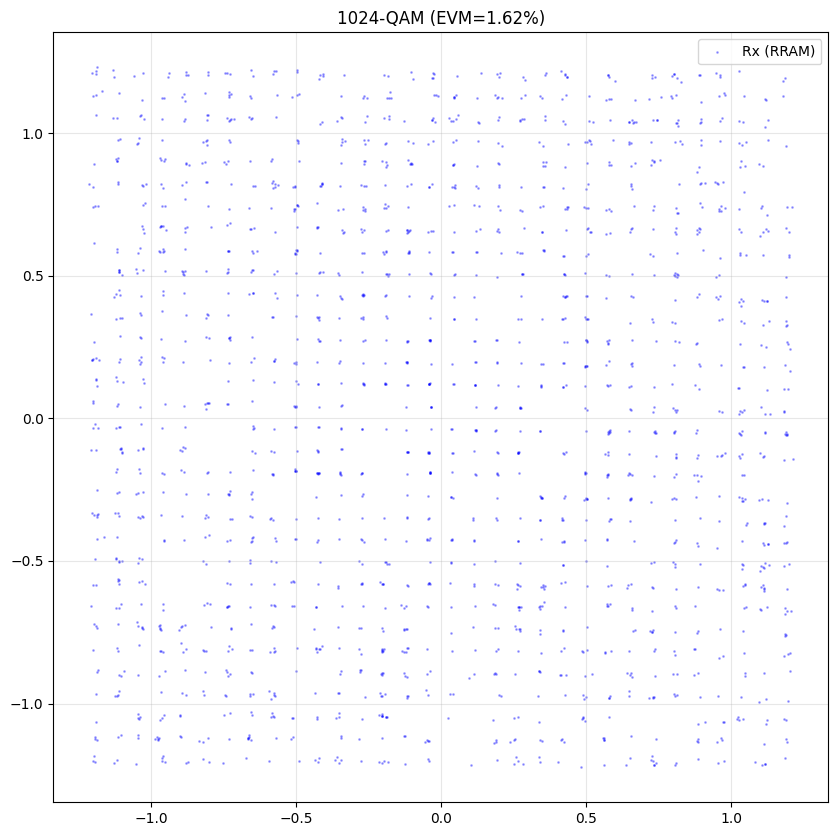

In [ ]:
# 1024-QAM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import firwin

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)

    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]

    return rram_matrix

def generate_lpf_coefficients(num_taps, cutoff_freq, sampling_freq):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    return firwin(num_taps, normalized_cutoff, window='hamming')

def create_toeplitz_matrix(coeffs, num_inputs):
    num_taps = len(coeffs)
    output_len = num_inputs + num_taps - 1
    toeplitz_matrix = np.zeros((num_inputs, output_len))
    for i in range(num_inputs):
        toeplitz_matrix[i, i:i+num_taps] = coeffs
    return toeplitz_matrix[:, :2*num_inputs]

def create_modulation_matrix(ideal_symbols, fc, t_sampled):
    N = len(t_sampled)
    num_symbols = len(ideal_symbols)
    mod_matrix = np.zeros((num_symbols, N))
    cos_carrier = np.cos(2 * np.pi * fc * t_sampled)
    sin_carrier = np.sin(2 * np.pi * fc * t_sampled)

    for i, symbol in enumerate(ideal_symbols):
        I_sym = np.real(symbol)
        Q_sym = np.imag(symbol)
        mod_matrix[i, :] = I_sym * cos_carrier - Q_sym * sin_carrier
    return mod_matrix

def add_awgn(signal, snr_db):
    if len(signal.shape) > 1:
        signal_power = np.mean(np.abs(signal)**2, axis=1, keepdims=True)
        if np.isinf(snr_db): return signal
        snr_linear = 10**(snr_db / 10.0)
        noise_power = signal_power / snr_linear
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    else:
        signal_power = np.mean(np.abs(signal)**2)
        if np.isinf(snr_db): return signal
        snr_linear = 10**(snr_db / 10.0)
        noise_power = signal_power / snr_linear
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def integrate_output(I_out, Q_out, N):
    if len(I_out.shape) > 1:
        num_symbols = I_out.shape[0]
        I_hats = np.zeros(num_symbols)
        Q_hats = np.zeros(num_symbols)
        ones_kernel = np.ones(N, dtype=float)

        for i in range(num_symbols):
            power = I_out[i]**2 + Q_out[i]**2
            energy = np.convolve(power, ones_kernel, mode='valid')
            start = int(np.argmax(energy)) if len(energy) > 0 else 0
            end = min(start + N, len(I_out[i]))
            I_hats[i] = np.sum(I_out[i, start:end])
            Q_hats[i] = np.sum(Q_out[i, start:end])
        return I_hats, Q_hats
    else:
        power = I_out**2 + Q_out**2
        if len(power) < N: return 0, 0
        energy = np.convolve(power, np.ones(N, dtype=float), mode='valid')
        if len(energy) == 0: return 0, 0
        start = int(np.argmax(energy))
        end = start + N
        return np.sum(I_out[start:end]), np.sum(Q_out[start:end])

def bits_to_symbol_indices(bits, bits_per_symbol):
    num_symbols = len(bits) // bits_per_symbol
    bits = bits[:num_symbols * bits_per_symbol]
    bits_reshaped = bits.reshape(-1, bits_per_symbol)
    powers_of_two = 1 << np.arange(bits_per_symbol)[::-1]
    return bits_reshaped @ powers_of_two

def symbol_indices_to_bits(indices, bits_per_symbol):
    n_symbols = len(indices)
    bits = np.zeros((n_symbols, bits_per_symbol), dtype=int)
    for i in range(bits_per_symbol):
        bits[:, i] = (indices >> (bits_per_symbol - 1 - i)) & 1
    return bits.flatten()

def decide_symbol_index(received_points, reference_symbols):
    dists = np.abs(received_points[:, None] - reference_symbols[None, :])
    return np.argmin(dists, axis=1)

def main():
    N = 64
    fs = 640e9; fc = 50e9
    num_lpf_taps = N + 1; lpf_cutoff = 50e9
    Ts = 1 / fs; t_sampled = np.arange(N) * Ts

    bits_per_symbol = 10
    M = 1024

    num_test_symbols = 200000
    total_bits = num_test_symbols * bits_per_symbol
    SNR_dB = 26
    read_noise_stddev_scaled = 0.0025

    g_min = 1e-3; g_max = 8e-3; states = 76; nonlinearity = 0.38

    print(f"--- Simulation Start: 1024-QAM ---")
    print(f"Freq: {fc/1e9}GHz, SNR: {SNR_dB}dB")

    b_coeffs = generate_lpf_coefficients(num_lpf_taps, lpf_cutoff, fs)
    lpf_toeplitz = create_toeplitz_matrix(b_coeffs, N)
    t = np.arange(N) / fs
    cos_carrier = np.cos(2 * np.pi * fc * t)
    sin_carrier_neg = -np.sin(2 * np.pi * fc * t)
    I_demod_ideal = np.diag(cos_carrier) @ lpf_toeplitz
    Q_demod_ideal = np.diag(sin_carrier_neg) @ lpf_toeplitz

    qam1024_points = []
    for i_val in range(-31, 32, 2):
        for q_val in range(-31, 32, 2):
            qam1024_points.append(i_val + 1j * q_val)
    ideal_symbols = np.array(qam1024_points)
    ideal_symbols = ideal_symbols / np.sqrt(np.mean(np.abs(ideal_symbols)**2))

    M_mod_ideal = create_modulation_matrix(ideal_symbols, fc, t_sampled)

    print("Mapping RRAM...")
    min_mod = M_mod_ideal.min(); offset_mod = -min_mod
    target_mod = M_mod_ideal + offset_mod
    max_mod = target_mod.max()
    G_mod_rram = map_weights_to_conductance_linear(target_mod, g_min, g_max, states, nonlinearity, max_mod)

    min_demod = min(I_demod_ideal.min(), Q_demod_ideal.min()); offset_demod = -min_demod
    I_target = I_demod_ideal + offset_demod; Q_target = Q_demod_ideal + offset_demod
    max_demod = max(I_target.max(), Q_target.max())
    G_I_rram = map_weights_to_conductance_linear(I_target, g_min, g_max, states, nonlinearity, max_demod)
    G_Q_rram = map_weights_to_conductance_linear(Q_target, g_min, g_max, states, nonlinearity, max_demod)

    gain_mod = max_mod / (g_max - g_min)
    gain_demod = max_demod / (g_max - g_min)

    cal_sym = ideal_symbols[0]
    cal_sig = np.real(cal_sym)*np.cos(2*np.pi*fc*t) - np.imag(cal_sym)*np.sin(2*np.pi*fc*t)
    I_meas, Q_meas = integrate_output(cal_sig @ I_demod_ideal, cal_sig @ Q_demod_ideal, N)
    scale_factor = (I_meas + 1j * Q_meas) / cal_sym if cal_sym != 0 else 1.0

    tx_bits = np.random.randint(0, 2, total_bits)
    tx_indices = bits_to_symbol_indices(tx_bits, bits_per_symbol)

    print("Processing...")
    mod_raw_batch = G_mod_rram[tx_indices]
    noise_scale_mod = read_noise_stddev_scaled * ((g_max - g_min) / max_mod)
    mod_noisy = mod_raw_batch + np.random.normal(0, noise_scale_mod, mod_raw_batch.shape)
    tx_sig = (mod_noisy - g_min) * gain_mod - offset_mod

    rx_sig = add_awgn(tx_sig, SNR_dB)

    I_out = rx_sig @ G_I_rram
    Q_out = rx_sig @ G_Q_rram
    noise_scale_demod = read_noise_stddev_scaled * ((g_max - g_min) / max_demod)
    I_out += np.random.normal(0, noise_scale_demod, I_out.shape)
    Q_out += np.random.normal(0, noise_scale_demod, Q_out.shape)

    rx_sums = np.sum(rx_sig, axis=1, keepdims=True)
    I_final = (I_out - g_min*rx_sums) * gain_demod - offset_demod*rx_sums
    Q_final = (Q_out - g_min*rx_sums) * gain_demod - offset_demod*rx_sums

    I_vals, Q_vals = integrate_output(I_final, Q_final, N)
    rx_points = (I_vals + 1j * Q_vals) / scale_factor

    rx_indices = decide_symbol_index(rx_points, ideal_symbols)
    rx_bits = symbol_indices_to_bits(rx_indices, bits_per_symbol)

    tx_points_ideal = ideal_symbols[tx_indices]
    evm = np.sqrt(np.mean(np.abs(rx_points - tx_points_ideal)**2)) / np.sqrt(np.mean(np.abs(ideal_symbols)**2)) * 100

    print(f"[Results] EVM: {evm:.2f}%")

    tx_points_ideal = ideal_symbols[tx_indices]
    df_const = pd.DataFrame({
        'Tx_Index': tx_indices,
        'Tx_Real': np.real(tx_points_ideal),
        'Tx_Imag': np.imag(tx_points_ideal),
        'Rx_Real': np.real(rx_points),
        'Rx_Imag': np.imag(rx_points)
    })

    csv_filename = 'rram_1024qam_constellation.csv'
    df_const.to_csv(csv_filename, index=False)
    print(f"Constellation points saved to '{csv_filename}'")

    plt.figure(figsize=(10, 10))
    plt.scatter(np.real(rx_points), np.imag(rx_points), c='blue', s=1, alpha=0.3, label='Rx (RRAM)')
    plt.title(f"1024-QAM (EVM={evm:.2f}%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == '__main__':
    main()

--- RRAM DFT Simulation (160GHz Band) ---
N (DFT Size): 64
Sampling Freq: 160.0 GHz

--- RRAM Device Parameters ---
Conductance: 1.0 ~ 8.0 mS
States: 76, Nonlinearity (v): 0.38

Mapping weights to RRAM (Offset Method)...
Mapping complete.

--- Simulation Data Saved to 'rram_dft_simulation_results.csv' ---


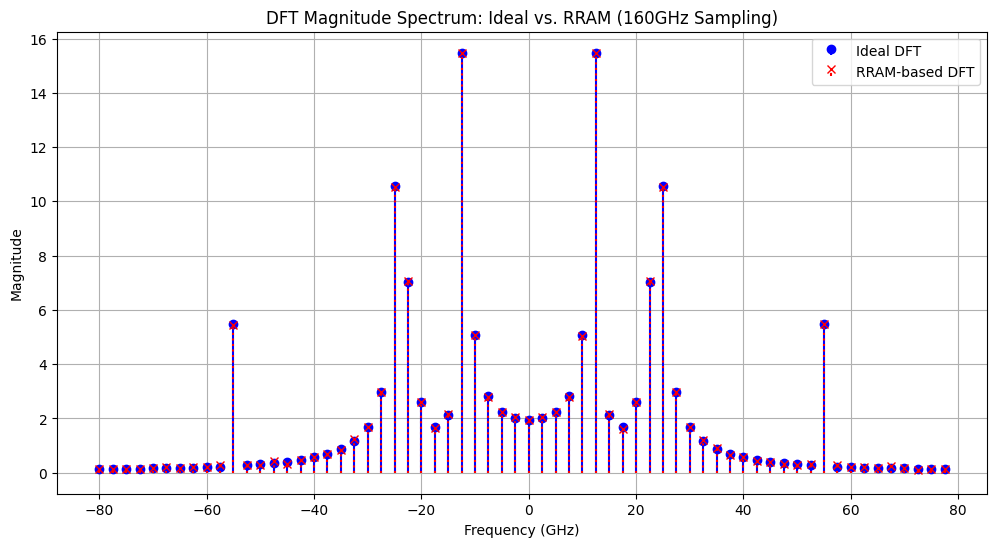

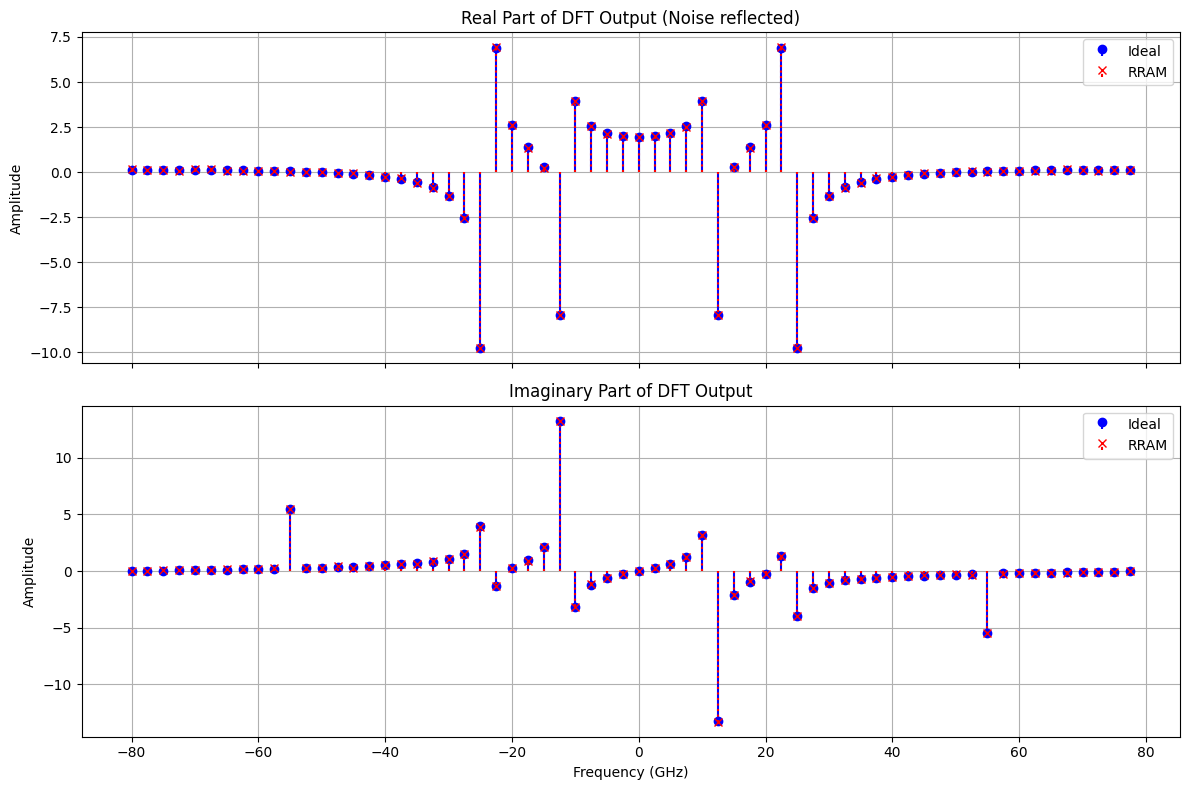

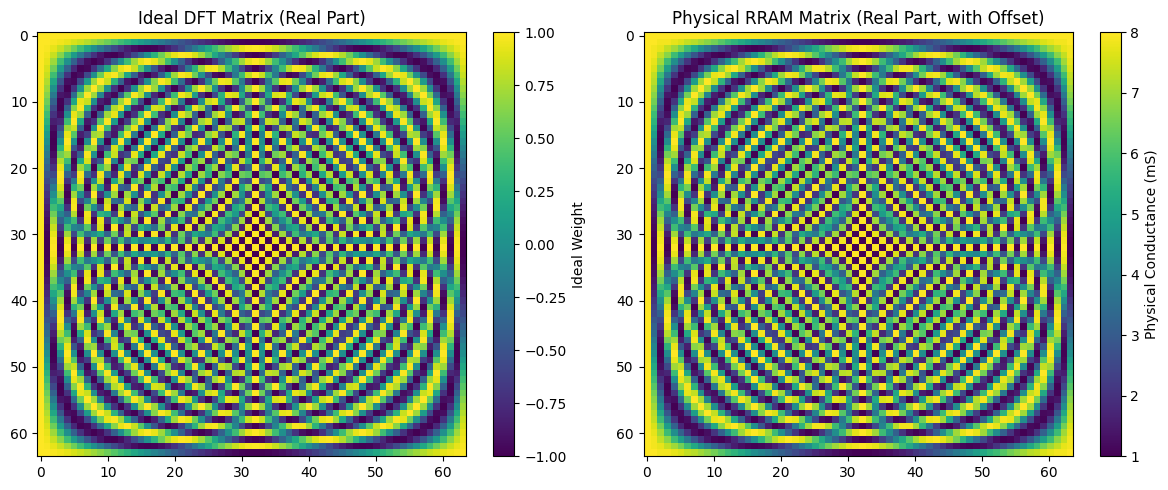

Mean Squared Error (Magnitude): 0.0010


In [ ]:
# DFT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)

    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)

    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]

    return rram_matrix

def main():
    N = 64
    fs = 160e9
    Ts = 1 / fs

    g_min_siemens = 1e-3
    g_max_siemens = 8e-3
    effective_states = 76
    nonlinearity_param = 0.38
    read_noise_std_scaled = 0.0025

    print("--- RRAM DFT Simulation (160GHz Band) ---")
    print(f"N (DFT Size): {N}")
    print(f"Sampling Freq: {fs/1e9:.1f} GHz")
    print(f"\n--- RRAM Device Parameters ---")
    print(f"Conductance: {g_min_siemens*1e3:.1f} ~ {g_max_siemens*1e3:.1f} mS")
    print(f"States: {effective_states}, Nonlinearity (v): {nonlinearity_param}\n")


    t_sampled = np.arange(N) * Ts
    f1, f2, f3 = 12e9, 24.0e9, 55.0e9


    raw_signal = (np.sin(2 * np.pi * f1 * t_sampled) +
                  0.8 * np.sin(2 * np.pi * f2 * t_sampled) +
                  0.3 * np.sin(2 * np.pi * f3 * t_sampled))
    input_vector = raw_signal / np.max(np.abs(raw_signal))


    n = np.arange(N)
    k = n.reshape((N, 1))
    WN = np.exp(-2j * np.pi * k * n / N)

    M_real_ideal = np.real(WN)
    M_imag_ideal = np.imag(WN)


    print("Mapping weights to RRAM (Offset Method)...")
    min_val = min(M_real_ideal.min(), M_imag_ideal.min())
    offset_D = -min_val
    M_real_target = M_real_ideal + offset_D
    M_imag_target = M_imag_ideal + offset_D


    max_target_val = max(M_real_target.max(), M_imag_target.max())
    G_real_rram = map_weights_to_conductance_linear(M_real_target, g_min_siemens, g_max_siemens, effective_states, nonlinearity_param, max_target_val)
    G_imag_rram = map_weights_to_conductance_linear(M_imag_target, g_min_siemens, g_max_siemens, effective_states, nonlinearity_param, max_target_val)

    print("Mapping complete.\n")


    V_in = input_vector.reshape((N, 1))


    I_real_out_raw = G_real_rram @ V_in
    I_imag_out_raw = G_imag_rram @ V_in


    noise_scale = read_noise_std_scaled * (g_max_siemens - g_min_siemens)
    I_real_out_raw += np.random.normal(0, noise_scale, I_real_out_raw.shape)
    I_imag_out_raw += np.random.normal(0, noise_scale, I_imag_out_raw.shape)


    gain = max_target_val / (g_max_siemens - g_min_siemens)
    input_sum = np.sum(V_in)
    g_min_bias = g_min_siemens * input_sum
    offset_bias = offset_D * input_sum

    def post_process(I_out_raw, gain, g_min_bias, offset_bias):
        I_removed_bias = I_out_raw - g_min_bias
        W_scaled = I_removed_bias * gain
        W_final = W_scaled - offset_bias
        return W_final.flatten()

    output_real_rram = post_process(I_real_out_raw, gain, g_min_bias, offset_bias)
    output_imag_rram = post_process(I_imag_out_raw, gain, g_min_bias, offset_bias)


    output_ideal = WN @ V_in
    output_real_ideal = np.real(output_ideal).flatten()
    output_imag_ideal = np.imag(output_ideal).flatten()


    freq_axis = np.fft.fftfreq(N, d=Ts) / 1e9
    freq_shifted = np.fft.fftshift(freq_axis)

    mag_rram = np.sqrt(output_real_rram**2 + output_imag_rram**2)
    mag_ideal = np.sqrt(output_real_ideal**2 + output_imag_ideal**2)

    mag_rram_shifted = np.fft.fftshift(mag_rram)
    mag_ideal_shifted = np.fft.fftshift(mag_ideal)

    real_rram_shifted = np.fft.fftshift(output_real_rram)
    real_ideal_shifted = np.fft.fftshift(output_real_ideal)

    imag_rram_shifted = np.fft.fftshift(output_imag_rram)
    imag_ideal_shifted = np.fft.fftshift(output_imag_ideal)


    results_df = pd.DataFrame({
        'Frequency_GHz': freq_shifted,
        'Magnitude_Ideal': mag_ideal_shifted,
        'Magnitude_RRAM': mag_rram_shifted,
        'Real_Ideal': real_ideal_shifted,
        'Real_RRAM': real_rram_shifted,
        'Imag_Ideal': imag_ideal_shifted,
        'Imag_RRAM': imag_rram_shifted
    })

    save_filename = 'rram_dft_simulation_results.csv'
    results_df.to_csv(save_filename, index=False)
    print(f"--- Simulation Data Saved to '{save_filename}' ---")


    plt.figure(figsize=(12, 6))
    plt.stem(freq_shifted, mag_ideal_shifted, linefmt='b-', markerfmt='bo', basefmt=" ", label='Ideal DFT')
    plt.stem(freq_shifted, mag_rram_shifted, linefmt='r:', markerfmt='rx', basefmt=" ", label='RRAM-based DFT')
    plt.title(f'DFT Magnitude Spectrum: Ideal vs. RRAM ({fs/1e9:.0f}GHz Sampling)')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Magnitude')
    plt.legend(); plt.grid(True); plt.show()


    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].stem(freq_shifted, real_ideal_shifted, linefmt='b-', markerfmt='bo', basefmt=" ", label='Ideal')
    axs[0].stem(freq_shifted, real_rram_shifted, linefmt='r:', markerfmt='rx', basefmt=" ", label='RRAM')
    axs[0].set_title('Real Part of DFT Output (Noise reflected)'); axs[0].set_ylabel('Amplitude')
    axs[0].legend(); axs[0].grid(True)

    axs[1].stem(freq_shifted, imag_ideal_shifted, linefmt='b-', markerfmt='bo', basefmt=" ", label='Ideal')
    axs[1].stem(freq_shifted, imag_rram_shifted, linefmt='r:', markerfmt='rx', basefmt=" ", label='RRAM')
    axs[1].set_title('Imaginary Part of DFT Output'); axs[1].set_xlabel('Frequency (GHz)'); axs[1].set_ylabel('Amplitude')
    axs[1].legend(); axs[1].grid(True)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(M_real_ideal, cmap='viridis', aspect='auto')
    plt.colorbar(label='Ideal Weight')
    plt.title('Ideal DFT Matrix (Real Part)')

    plt.subplot(1, 2, 2)
    plt.imshow(G_real_rram * 1e3, cmap='viridis', aspect='auto')
    plt.colorbar(label='Physical Conductance (mS)')
    plt.title('Physical RRAM Matrix (Real Part, with Offset)')
    plt.tight_layout()
    plt.show()

    mse = np.mean(np.abs(mag_rram - mag_ideal)**2)
    print(f"Mean Squared Error (Magnitude): {mse:.4f}")

if __name__ == '__main__':
    main()

--- 2x2 MIMO MMSE Detection (4-QAM Mode) ---
RRAM: 76 States, Noise=0.25%

=== Overall Results (SNR=12dB) ===
RRAM Average BER: 0.000508
RRAM Average SER: 0.001015

--- Saving Summary Results to CSV ---
1. 'mimo_4qam_rram_summary.csv' saved.
--- Saving Signal IQ Data (All Symbols) ---
2. 'mimo_4qam_iq_signals.csv' saved.


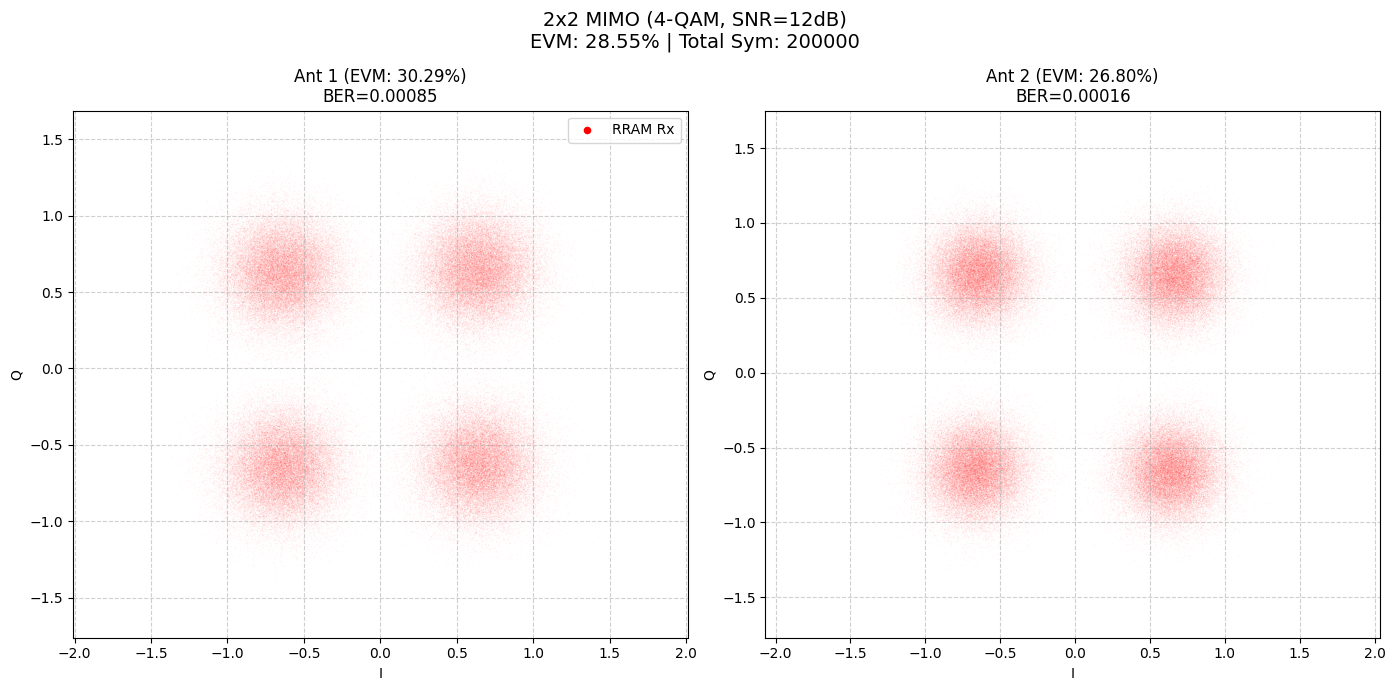

In [ ]:
#4QAM 2x2 MIMO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)
    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    rram_matrix = np.zeros_like(scaled_matrix)
    for i in range(scaled_matrix.shape[0]):
        for j in range(scaled_matrix.shape[1]):
            target_val = scaled_matrix[i, j]
            closest_idx = np.argmin(np.abs(achievable_conductances_lut - target_val))
            rram_matrix[i, j] = achievable_conductances_lut[closest_idx]
    return rram_matrix

def complex_to_real_matrix_expansion(W_complex):
    Rows, Cols = W_complex.shape
    W_real_expanded = np.zeros((2*Rows, 2*Cols))
    W_real_expanded[0:Rows, 0:Cols] = np.real(W_complex)
    W_real_expanded[0:Rows, Cols:]  = -np.imag(W_complex)
    W_real_expanded[Rows:, 0:Cols]  = np.imag(W_complex)
    W_real_expanded[Rows:, Cols:]   = np.real(W_complex)
    return W_real_expanded

def complex_to_real_vector_expansion(y_complex):
    return np.concatenate((np.real(y_complex), np.imag(y_complex)))

def real_to_complex_vector_restoration(x_real_expanded):
    N = len(x_real_expanded) // 2
    return x_real_expanded[:N] + 1j * x_real_expanded[N:]

def gray_to_binary(n):
    mask = n
    while mask != 0:
        mask >>= 1
        n ^= mask
    return n

def generate_gray_qam_constellation(M):
    bits_per_symbol = int(np.log2(M))
    constellation = np.zeros(M, dtype=complex)

    if M == 4:
        for i in range(M):
            i_bit = (i >> 1) & 1
            q_bit = i & 1
            i_idx = gray_to_binary(i_bit)
            q_idx = gray_to_binary(q_bit)
            I_val = 2 * i_idx - 1
            Q_val = 2 * q_idx - 1
            constellation[i] = I_val + 1j * Q_val

    elif M == 16:
        k_half = 2
        mask_half = 0x3
        for i in range(M):
            i_bits_gray = (i >> k_half) & mask_half
            q_bits_gray = i & mask_half
            i_idx = gray_to_binary(i_bits_gray)
            q_idx = gray_to_binary(q_bits_gray)
            I_val = 2 * i_idx - 3
            Q_val = 2 * q_idx - 3
            constellation[i] = I_val + 1j * Q_val

    return constellation / np.sqrt(np.mean(np.abs(constellation)**2))

def bits_to_indices(bits, bits_per_symbol):
    n_symbols = len(bits) // bits_per_symbol
    bits_reshaped = bits[:n_symbols*bits_per_symbol].reshape(n_symbols, bits_per_symbol)
    powers = 1 << np.arange(bits_per_symbol)[::-1]
    return bits_reshaped @ powers

def indices_to_bits(indices, bits_per_symbol):
    n_symbols = len(indices)
    bits = np.zeros((n_symbols, bits_per_symbol), dtype=int)
    for i in range(bits_per_symbol):
        shift = bits_per_symbol - 1 - i
        bits[:, i] = (indices >> shift) & 1
    return bits.flatten()

def calculate_evm(x_ideal, x_rx):
    Nt, num_symbols = x_ideal.shape
    evm_per_antenna = []

    error_vector = x_rx - x_ideal

    for i in range(Nt):
        p_avg = np.mean(np.abs(x_ideal[i, :])**2)

        mse = np.mean(np.abs(error_vector[i, :])**2)

        evm_rms = np.sqrt(mse / p_avg) * 100
        evm_per_antenna.append(evm_rms)

    overall_evm_percent = np.mean(evm_per_antenna)

    safe_evm = max(overall_evm_percent, 1e-10)

    return overall_evm_percent, safe_evm, evm_per_antenna

def run_mimo_simulation(Nt, Nr, M_QAM, SNR_dB, num_symbols, rram_params):
    g_min, g_max, num_states, nonlinearity, read_noise_std = rram_params
    bits_per_symbol = int(np.log2(M_QAM))
    total_bits_per_stream = num_symbols * bits_per_symbol

    constellation = generate_gray_qam_constellation(M_QAM)
    tx_bits_streams = []
    tx_indices_streams = []
    x_tx = np.zeros((Nt, num_symbols), dtype=complex)

    for i in range(Nt):
        bits = np.random.randint(0, 2, total_bits_per_stream)
        indices = bits_to_indices(bits, bits_per_symbol)
        tx_bits_streams.append(bits)
        tx_indices_streams.append(indices)
        x_tx[i, :] = constellation[indices]

    H = (np.random.randn(Nr, Nt) + 1j * np.random.randn(Nr, Nt)) / np.sqrt(2)
    Es = 1.0
    N0 = Es / (10**(SNR_dB/10))
    noise = (np.random.randn(Nr, num_symbols) + 1j * np.random.randn(Nr, num_symbols)) * np.sqrt(N0/2)
    y_rx = H @ x_tx + noise

    H_herm = H.conj().T
    W_mmse_complex = np.linalg.inv(H_herm @ H + N0 * np.eye(Nt)) @ H_herm
    W_mmse_real = complex_to_real_matrix_expansion(W_mmse_complex)

    min_val = np.min(W_mmse_real)
    offset_D = -min_val
    W_target = W_mmse_real + offset_D
    max_target_val = np.max(W_target)
    G_rram = map_weights_to_conductance_linear(W_target, g_min, g_max, num_states, nonlinearity, max_target_val)

    y_rx_real = complex_to_real_vector_expansion(y_rx)
    gain_slope = (g_max - g_min) / max_target_val if max_target_val > 0 else 1
    I_out_raw = G_rram @ y_rx_real

    current_noise_scale = np.max(np.abs(I_out_raw)) * read_noise_std
    I_out_noisy = I_out_raw + np.random.normal(0, current_noise_scale, I_out_raw.shape)

    y_sum = np.sum(y_rx_real, axis=0)
    I_removed_bias = I_out_noisy - (g_min * y_sum)
    W_scaled_out = I_removed_bias / gain_slope
    x_hat_real_rram = W_scaled_out - (offset_D * y_sum)
    x_hat_rram = real_to_complex_vector_restoration(x_hat_real_rram)
    x_hat_ideal = x_tx

    def detect_and_count_errors(signal_complex, tx_indices, tx_bits, constellation, bps):
        total_bit_err, total_sym_err = 0, 0
        per_ant = []
        for ant in range(signal_complex.shape[0]):
            points = signal_complex[ant, :]
            dists = np.abs(points[:, None] - constellation[None, :])
            det_idx = np.argmin(dists, axis=1)

            true_idx = tx_indices[ant]
            sym_err = np.sum(det_idx != true_idx)

            det_bits = indices_to_bits(det_idx, bps)
            true_bits = tx_bits[ant]
            bit_err = np.sum(det_bits != true_bits)

            total_bit_err += bit_err
            total_sym_err += sym_err
            per_ant.append({'ber': bit_err/len(true_bits), 'ser': sym_err/len(true_idx)})
        return total_bit_err, total_sym_err, per_ant

    bit_err_rram, sym_err_rram, stats_rram = detect_and_count_errors(
        x_hat_rram, tx_indices_streams, tx_bits_streams, constellation, bits_per_symbol)

    total_bits = Nt * num_symbols * bits_per_symbol
    total_syms = Nt * num_symbols

    return bit_err_rram/total_bits, sym_err_rram/total_syms, x_hat_ideal, x_hat_rram, constellation, stats_rram

def main():
    Nt, Nr = 2, 2
    M_QAM = 4
    SNR_dB = 12
    num_symbols = 200000
    np.random.seed(20)
    g_min, g_max, num_states, nonlinearity, read_noise_std = 1e-3, 8e-3, 76, 0.38, 0.0025
    rram_params = (g_min, g_max, num_states, nonlinearity, read_noise_std)

    print(f"--- {Nt}x{Nr} MIMO MMSE Detection (4-QAM Mode) ---")
    print(f"RRAM: {num_states} States, Noise={read_noise_std*100}%")

    ber, ser, x_ideal, x_rram, constellation, stats = run_mimo_simulation(
        Nt, Nr, M_QAM, SNR_dB, num_symbols, rram_params
    )

    evm_pct, evm_db, evm_per_ant = calculate_evm(x_ideal, x_rram)

    print(f"\n=== Overall Results (SNR={SNR_dB}dB) ===")
    print(f"RRAM Average BER: {ber:.6f}")
    print(f"RRAM Average SER: {ser:.6f}")

    print("\n--- Saving Summary Results to CSV ---")

    summary_list = []
    for i, stat in enumerate(stats):
        summary_list.append({
            'Timestamp': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Antenna': i + 1,
            'SNR_dB': SNR_dB,
            'Total_BER': ber,
            'Total_SER': ser,
            'Total_EVM_Pct': evm_pct,
            'Total_EVM_dB': evm_db,
            'Antenna_BER': stat['ber'],
            'Antenna_SER': stat['ser'],
            'Antenna_EVM_Pct': evm_per_ant[i],
            'M_QAM': M_QAM,
            'num_states': num_states,
            'nonlinearity': nonlinearity,
            'read_noise_std': read_noise_std
        })

    df_summary = pd.DataFrame(summary_list)
    df_summary.to_csv('mimo_4qam_rram_summary.csv', index=False, encoding='utf-8-sig')
    print("1. 'mimo_4qam_rram_summary.csv' saved.")

    print("--- Saving Signal IQ Data (All Symbols) ---")

    signal_data = {}
    for i in range(Nt):
        signal_data[f'Ant{i+1}_Rx_I'] = np.real(x_rram[i, :])
        signal_data[f'Ant{i+1}_Rx_Q'] = np.imag(x_rram[i, :])
        signal_data[f'Ant{i+1}_Tx_I'] = np.real(x_ideal[i, :])
        signal_data[f'Ant{i+1}_Tx_Q'] = np.imag(x_ideal[i, :])

    df_signals = pd.DataFrame(signal_data)
    df_signals.to_csv('mimo_4qam_iq_signals.csv', index=False)
    print("2. 'mimo_4qam_iq_signals.csv' saved.")

    plt.figure(figsize=(14, 7))
    plt.suptitle(f"{Nt}x{Nr} MIMO (4-QAM, SNR={SNR_dB}dB)\nEVM: {evm_pct:.2f}% | Total Sym: {num_symbols}", fontsize=14)

    for i in range(Nt):
        plt.subplot(1, Nt, i+1)
        plt.title(f"Ant {i+1} (EVM: {evm_per_ant[i]:.2f}%)\nBER={stats[i]['ber']:.5f}")
        plt.scatter(np.real(x_rram[i, :]), np.imag(x_rram[i, :]),
                    c='red', s=0.5, alpha=0.05, label='RRAM Rx', edgecolors='none')
        plt.xlabel('I'); plt.ylabel('Q'); plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim([-2.5, 2.5]); plt.ylim([-2.5, 2.5]); plt.axis('equal')
        if i == 0:
            leg = plt.legend(loc='upper right')
            for lh in leg.legend_handles:
                lh.set_alpha(1); lh._sizes = [30]

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

--- 6G Massive MIMO CSI Compression (Unified Simulation) ---
Target Total Symbols: 200000
Training AI Model...
Training Complete.
Reconstructing Channels via RRAM Matrix...

[Result] Ideal NMSE: -5.90 dB
[Result] RRAM NMSE: -2.48 dB

Starting Communication Simulation...
SNR 0dB -> Tested 200000 symbols. RRAM SER: 0.623050
SNR 4dB -> Tested 200000 symbols. RRAM SER: 0.421615
SNR 8dB -> Tested 200000 symbols. RRAM SER: 0.201470
SNR 12dB -> Tested 200000 symbols. RRAM SER: 0.062265
SNR 16dB -> Tested 200000 symbols. RRAM SER: 0.013820
SNR 20dB -> Tested 200000 symbols. RRAM SER: 0.002380
  >> Captured 200000 points for visualization.
SNR 24dB -> Tested 200000 symbols. RRAM SER: 0.000295

[Saved] NMSE results to 'simulation_nmse_results.csv'
[Saved] SER results to 'simulation_ser_results_unified.csv'
[Saved] 200000 points of Constellation data.


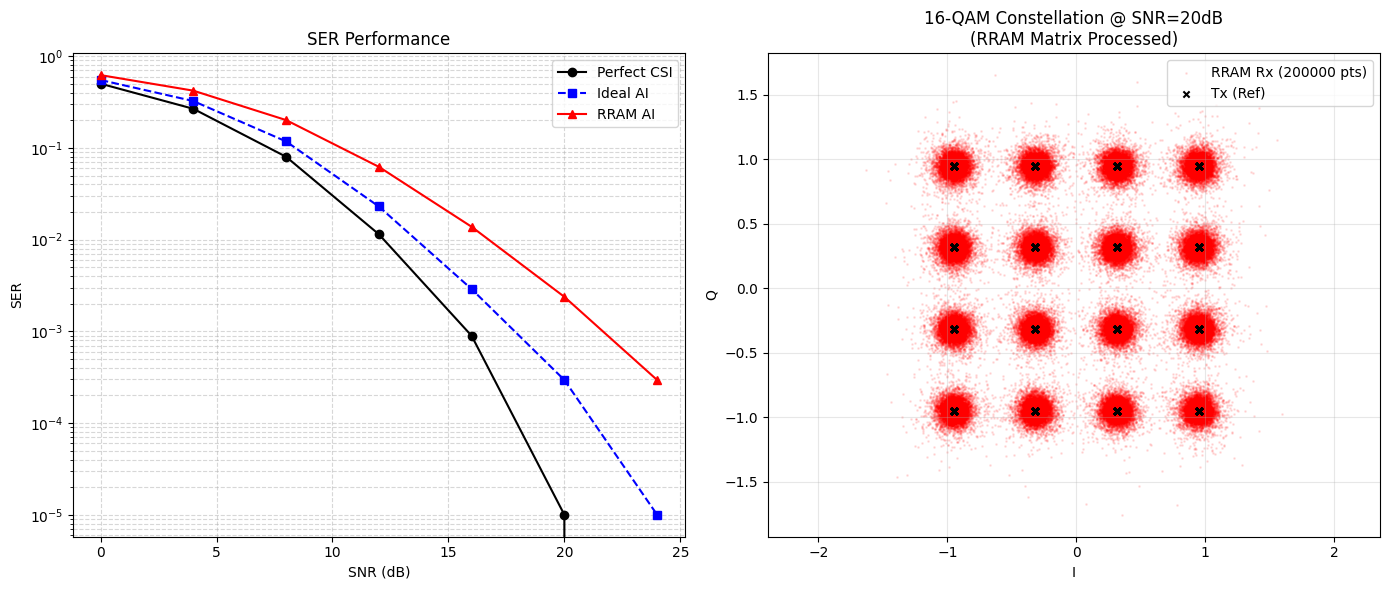

In [ ]:
# CSI encoding

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os

TOTAL_TEST_SYMBOLS = 200000  # 원하는 심볼 개수
VIZ_SNR_TARGET = 20          # 성상도 확인 목표 SNR (dB)

def map_weights_to_conductance_linear(weights_matrix, g_min, g_max, num_states, non_linearity, max_weight_for_scaling):
    if num_states <= 1: return np.full_like(weights_matrix, g_min)
    p_levels = np.linspace(0, 1, num_states)
    alpha = 1 + non_linearity
    p_nonlinear = p_levels ** alpha
    achievable_conductances_lut = g_min + p_nonlinear * (g_max - g_min)

    if max_weight_for_scaling == 0: return np.full_like(weights_matrix, g_min)

    scaled_matrix = g_min + (weights_matrix / max_weight_for_scaling) * (g_max - g_min)
    scaled_matrix = np.clip(scaled_matrix, g_min, g_max)

    shape = scaled_matrix.shape
    scaled_flat = scaled_matrix.flatten()

    diff = np.abs(scaled_flat[:, np.newaxis] - achievable_conductances_lut)
    closest_indices = np.argmin(diff, axis=1)
    rram_flat = achievable_conductances_lut[closest_indices]

    return rram_flat.reshape(shape)

class CSI_Autoencoder(nn.Module):
    def __init__(self, input_dim, compressed_dim):
        super(CSI_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, compressed_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(compressed_dim, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

def generate_channel_data(num_samples, Nt):
    H_complex = (np.random.randn(num_samples, Nt) + 1j * np.random.randn(num_samples, Nt)) / np.sqrt(2)
    H_real = np.concatenate([np.real(H_complex), np.imag(H_complex)], axis=1)
    return torch.FloatTensor(H_real), H_complex

def qam16_modulator(num_symbols):
    levels = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    real_parts = np.random.choice(levels, num_symbols)
    imag_parts = np.random.choice(levels, num_symbols)
    return real_parts + 1j * imag_parts

def qam16_demodulator_hard(received_symbols):
    levels = np.array([-3, -1, 1, 3]) / np.sqrt(10)
    constellation = np.array([r + 1j*i for r in levels for i in levels])
    dists = np.abs(received_symbols[:, None] - constellation[None, :])
    return constellation[np.argmin(dists, axis=1)]

def rram_inference(input_vector, weight_matrix, bias_vector, rram_params):
    g_min, g_max, num_states, nonlinearity, read_noise_std = rram_params
    weight_matrix = np.clip(weight_matrix, -1.0, 1.0)
    min_w = np.min(weight_matrix)
    offset_w = -min_w if min_w < 0 else 0
    target_w = weight_matrix + offset_w
    max_w = np.max(target_w)
    G_rram = map_weights_to_conductance_linear(target_w, g_min, g_max, num_states, nonlinearity, max_w)
    gain_slope = (g_max - g_min) / max_w if max_w > 0 else 1

    I_out_raw = input_vector @ G_rram.T
    noise_scale = np.mean(np.abs(I_out_raw)) * read_noise_std
    I_out_noisy = I_out_raw + np.random.normal(0, noise_scale, I_out_raw.shape)

    input_sum = np.sum(input_vector, axis=1, keepdims=True)
    I_removed_bias = I_out_noisy - (input_sum * g_min)
    output = (I_removed_bias / gain_slope) - (input_sum * offset_w)

    if bias_vector is not None: output += bias_vector
    return output

def main():

    SEED = 20
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

    Nt = 4; Input_Dim = 2 * Nt; Compression_Ratio = 2
    Compressed_Dim = Input_Dim // Compression_Ratio
    Num_Train = 10000; Num_Test = 1000; Epochs = 2000
    rram_params = (1e-3, 8e-3, 76, 0.38, 0.0025)

    print(f"--- 6G Massive MIMO CSI Compression (Unified Simulation) ---")
    print(f"Target Total Symbols: {TOTAL_TEST_SYMBOLS}")

    train_data, _ = generate_channel_data(Num_Train, Nt)
    test_data, test_data_complex = generate_channel_data(Num_Test, Nt)

    model = CSI_Autoencoder(Input_Dim, Compressed_Dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    print("Training AI Model...")
    model.train()
    for epoch in range(Epochs):
        optimizer.zero_grad()
        loss = criterion(model(train_data), train_data)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for param in model.parameters(): param.clamp_(-1.0, 1.0)
    print("Training Complete.")

    model.eval()
    def rram_encoder_forward(x_input, model, params):
        x_np = x_input.detach().numpy()
        out1 = rram_inference(x_np, model.encoder[0].weight.detach().numpy(), model.encoder[0].bias.detach().numpy(), params)
        out1_act = model.encoder[2](model.encoder[1](torch.FloatTensor(out1)))
        out2 = rram_inference(out1_act.detach().numpy(), model.encoder[3].weight.detach().numpy(), model.encoder[3].bias.detach().numpy(), params)
        out2_act = model.encoder[4](torch.FloatTensor(out2))
        out3 = rram_inference(out2_act.detach().numpy(), model.encoder[5].weight.detach().numpy(), model.encoder[5].bias.detach().numpy(), params)
        return torch.FloatTensor(out3)

    print("Reconstructing Channels via RRAM Matrix...")
    encoded_ideal = model.encoder(test_data)
    decoded_ideal = model.decoder(encoded_ideal)

    encoded_rram = rram_encoder_forward(test_data, model, rram_params)
    decoded_rram = model.decoder(encoded_rram)

    def calc_nmse(original, reconstructed):
        orig_np = original.detach().numpy()
        recon_np = reconstructed.detach().numpy()

        mse = np.mean((orig_np - recon_np)**2)
        power = np.mean(orig_np**2)
        return 10 * np.log10(mse / power)

    nmse_ideal = calc_nmse(test_data, decoded_ideal)
    nmse_rram = calc_nmse(test_data, decoded_rram)

    print(f"\n[Result] Ideal NMSE: {nmse_ideal:.2f} dB")
    print(f"[Result] RRAM NMSE: {nmse_rram:.2f} dB")

    H_recon_ideal = decoded_ideal.detach().numpy()[:, :Nt] + 1j * decoded_ideal.detach().numpy()[:, Nt:]
    H_recon_rram = decoded_rram.detach().numpy()[:, :Nt] + 1j * decoded_rram.detach().numpy()[:, Nt:]
    H_true = test_data_complex

    snr_range = np.arange(0, 25, 4)
    ser_results = []

    saved_constellation_data = None

    print("\nStarting Communication Simulation...")

    for snr in snr_range:
        n0 = 1.0 / (10**(snr/10.0))
        err_p_total = 0; err_i_total = 0; err_r_total = 0

        collect_data = (snr == VIZ_SNR_TARGET)

        if collect_data:
            list_tx = []; list_rx_p = []; list_rx_i = []; list_rx_r = []

        batch_size = 1000
        num_batches = int(np.ceil(TOTAL_TEST_SYMBOLS / batch_size))
        processed_symbols = 0

        for b in range(num_batches):
            current_batch_size = min(batch_size, TOTAL_TEST_SYMBOLS - processed_symbols)
            ch_idx = b % len(H_true)

            h_t = H_true[ch_idx]
            h_i = H_recon_ideal[ch_idx]
            h_r = H_recon_rram[ch_idx]

            w_p = np.conj(h_t)/np.linalg.norm(h_t)
            w_i = np.conj(h_i)/np.linalg.norm(h_i)
            w_r = np.conj(h_r)/np.linalg.norm(h_r)

            s_batch = qam16_modulator(current_batch_size)
            noise = np.sqrt(n0/2) * (np.random.randn(current_batch_size) + 1j*np.random.randn(current_batch_size))

            y_p = h_t @ np.outer(w_p, s_batch) + noise
            y_i = h_t @ np.outer(w_i, s_batch) + noise
            y_r = h_t @ np.outer(w_r, s_batch) + noise

            rx_p = y_p / (h_t @ w_p)
            rx_i = y_i / (h_t @ w_i)
            rx_r = y_r / (h_t @ w_r)

            d_p = qam16_demodulator_hard(rx_p)
            d_i = qam16_demodulator_hard(rx_i)
            d_r = qam16_demodulator_hard(rx_r)

            err_p_total += np.sum(d_p != s_batch)
            err_i_total += np.sum(d_i != s_batch)
            err_r_total += np.sum(d_r != s_batch)

            if collect_data:
                list_tx.append(s_batch.flatten())
                list_rx_p.append(rx_p.flatten())
                list_rx_i.append(rx_i.flatten())
                list_rx_r.append(rx_r.flatten())

            processed_symbols += current_batch_size

        ser_p = err_p_total / TOTAL_TEST_SYMBOLS
        ser_i = err_i_total / TOTAL_TEST_SYMBOLS
        ser_r = err_r_total / TOTAL_TEST_SYMBOLS

        print(f"SNR {snr}dB -> Tested {TOTAL_TEST_SYMBOLS} symbols. RRAM SER: {ser_r:.6f}")
        ser_results.append([snr, ser_p, ser_i, ser_r])

        if collect_data:
            saved_constellation_data = {
                'Tx': np.concatenate(list_tx).flatten(),
                'Rx_Perfect': np.concatenate(list_rx_p).flatten(),
                'Rx_Ideal': np.concatenate(list_rx_i).flatten(),
                'Rx_RRAM': np.concatenate(list_rx_r).flatten()
            }
            print(f"  >> Captured {len(saved_constellation_data['Tx'])} points for visualization.")

    df_nmse = pd.DataFrame({
        'Metric': ['Ideal_NMSE_dB', 'RRAM_NMSE_dB'],
        'Value': [nmse_ideal, nmse_rram]
    })
    df_nmse.to_csv('simulation_nmse_results.csv', index=False)
    print("\n[Saved] NMSE results to 'simulation_nmse_results.csv'")

    df_ser = pd.DataFrame(ser_results, columns=['SNR_dB', 'SER_Perfect', 'SER_Ideal_AI', 'SER_RRAM_AI'])
    df_ser.to_csv('simulation_ser_results_unified.csv', index=False)
    print("[Saved] SER results to 'simulation_ser_results_unified.csv'")

    if saved_constellation_data is not None:
        df_const = pd.DataFrame({
            'Tx_Real': np.real(saved_constellation_data['Tx']),
            'Tx_Imag': np.imag(saved_constellation_data['Tx']),
            'Rx_RRAM_Real': np.real(saved_constellation_data['Rx_RRAM']),
            'Rx_RRAM_Imag': np.imag(saved_constellation_data['Rx_RRAM']),
        })
        df_const.to_csv('qam_constellation_data_unified.csv', index=False)
        print(f"[Saved] {TOTAL_TEST_SYMBOLS} points of Constellation data.")
    else:
        print("[Warning] Target VIZ_SNR was not in the snr_range.")

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.semilogy(df_ser['SNR_dB'], df_ser['SER_Perfect'], 'k-o', label='Perfect CSI')
    plt.semilogy(df_ser['SNR_dB'], df_ser['SER_Ideal_AI'], 'b--s', label='Ideal AI')
    plt.semilogy(df_ser['SNR_dB'], df_ser['SER_RRAM_AI'], 'r-^', label='RRAM AI')
    plt.title(f'SER Performance')
    plt.xlabel('SNR (dB)'); plt.ylabel('SER')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    if saved_constellation_data is not None:
        plt.subplot(1, 2, 2)

        rx_data = saved_constellation_data['Rx_RRAM'].flatten()
        plt.scatter(np.real(rx_data), np.imag(rx_data),
                    c='r', s=1, alpha=0.1, label=f'RRAM Rx ({TOTAL_TEST_SYMBOLS} pts)')

        tx_data = saved_constellation_data['Tx'].flatten()
        limit = min(1000, len(tx_data))
        plt.scatter(np.real(tx_data[:limit]), np.imag(tx_data[:limit]),
                    c='k', marker='x', s=20, label='Tx (Ref)')

        plt.title(f'16-QAM Constellation @ SNR={VIZ_SNR_TARGET}dB\n(RRAM Matrix Processed)')
        plt.xlabel('I'); plt.ylabel('Q')
        plt.axis('equal'); plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()